# CODE: Code for Optimizing Docking Enrichments

In [1]:
#Importa los paquetes necesarios
%pylab inline

import csv, os, random, sys, shutil
from emcee_code import emcee_code_function, modelo
from optparse import OptionParser
import numpy
numpy.set_printoptions(threshold=numpy.nan)

tamano=14

Populating the interactive namespace from numpy and matplotlib


In [2]:
ResultsDatabase=genfromtxt('Input.csv', delimiter=',')
Nombre='test'
inputfile='Input.csv' 

numParam=3
mayomen=[]

for i in range(0, numParam):
    mayomen.append(-1)
#mayomen=[-1,-1,-1,-1,-1,-1] #-1 si entre menor mejor y 1 si entre mayor mejor

numTrainMol=105
semilla=1
thresAct=1 #Por debajo (o igual) a este valor se considera el compuesto activo

coluAct=2
coluMIC=3

pesot=5
thresComp=25
descrp=0
ndxchg=0

#########################################################################################################################

if os.path.exists(Nombre)==True:
    sys.exit("There is already a job with the same name. Please change it. I will not override it to then see you mad at me.")
if os.path.exists(Nombre)==False:
    os.mkdir(Nombre)

shutil.copy(inputfile, Nombre)
os.rename(Nombre+'/'+inputfile, Nombre+'/'+Nombre+'In.csv' )
Datos=genfromtxt(Nombre + '/'+Nombre+'In.csv', delimiter=',', skip_header=1) 

In [3]:
def arreglar(array):
    
    ignorar=len(array[0,:])-numParam-1
    
#Normaliza valores de las columnas    
    for j in range (0, numParam):
        norm=0
        colu=ignorar+j
        minimo=min(array[:,colu])
        maximo=max(array[:,colu])
        
        if mayomen[j]==-1:
            for k in range(0, len(array[:,colu])):
                array[k,colu]=array[k,colu]-maximo
            norm=min(array[:,colu])
            for l in range(0, len(array[:,colu])):
                array[l,colu]=array[l,colu]/norm
                
        if mayomen[j]==1:
            for m in range(0, len(array[:, colu])):
                array[m, colu]=array[m,colu]-minimo
            norm=max(array[:,colu])
            for n in range(0, len(array[:,colu])):
                array[n, colu]=array[n, colu]/norm 
    
#Asigna valor boolean a coluAct    
    for o in range(0,len(array[:,0])):
        if (array[o, coluMIC]<=thresAct):
            array[o,coluAct]=1
        if (array[o, coluMIC]>thresAct):
            array[o,coluAct]=2
    return array

In [4]:
#Arregla input
DatosArreg=arreglar(Datos)

#Asigna ciertas filas al training set
filasTrain=[]
TrainSet=zeros((numTrainMol, len(Datos[0,:])))

for i in range(len(DatosArreg[0,:])):
    random.seed(semilla)
    filasTrain=random.sample(range(len(DatosArreg[:,0])), numTrainMol)
    
ndx=0
for j in range(0, len(DatosArreg[:,0])):
    if ((j in filasTrain)==True):
        TrainSet[ndx,:]=DatosArreg[j,:]
        ndx+=1 

#Asigna ciertas filas al test set
filasTest=[]
TestSet=zeros((len(Datos[:,0])-numTrainMol,len(Datos[0,:])))

for i in range(0, len(DatosArreg[:,0])):
    if ((i in filasTrain)==False):
        filasTest.append(i)
        
ndx=0
for k in range(0, len(DatosArreg[:,0])):
    if ((k in filasTest)==True):
        TestSet[ndx,:]=DatosArreg[k,:]
        ndx += 1

#Crea matriz con las propiedades a usar
matriz_propiedades_train = TrainSet[:,len(TrainSet[0,:])-1-numParam:(len(TrainSet[0,:])-1)]
matriz_propiedades_test = TestSet[:,len(TestSet[0,:])-1-numParam:(len(TestSet[0,:])-1)]
matriz_propiedades = DatosArreg[:,len(DatosArreg[0,:])-1-numParam:(len(DatosArreg[0,:])-1)]

print shape(matriz_propiedades)
print shape(matriz_propiedades_test)
print shape(matriz_propiedades_train)
#Crea arreglo con solo datos de actividad experimental
mic_train = TrainSet[:,coluMIC]  
mic_test = TestSet[:,coluMIC]  

(145, 3)
(40, 3)
(105, 3)


## MonteCarlo

Mean acceptance fraction: 0.625 (Should be between 0.25 and 0.5 approximately)
Parameter = [16 50 84]
('alfa1 = ', array([ 4.13786263,  5.6322283 ,  6.82499384]))
('alfa2 = ', array([  5.38701096,   8.6820746 ,  12.10718408]))
('alfa3 = ', array([-11.27464056,  -5.00409392,  -2.34593463]))
[ 5.6322283   8.6820746  -5.00409392]


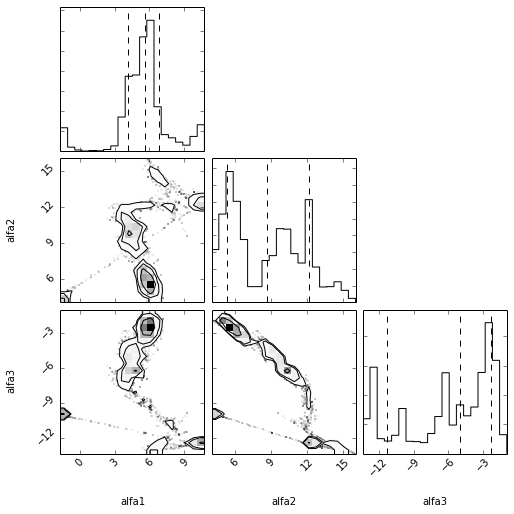

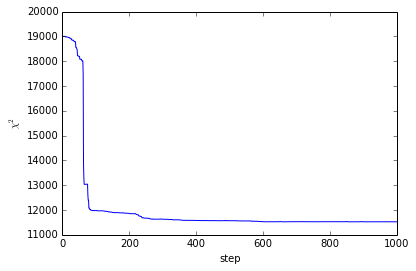

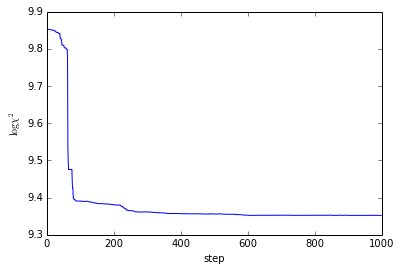

In [5]:
parametros_emcee = emcee_code_function(matriz_propiedades_train, mic_train, semilla, Nombre)
parametros_sin_error = parametros_emcee[:,1]
print parametros_sin_error

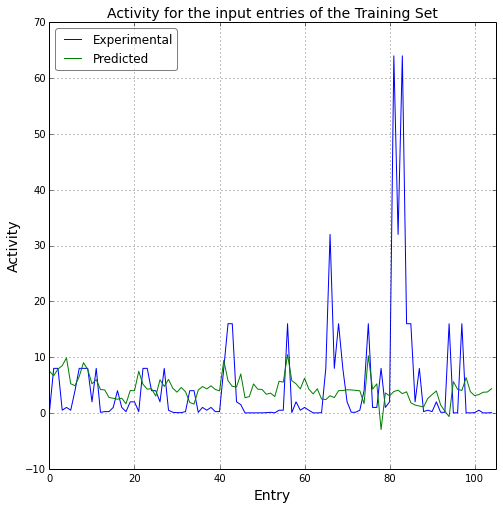

In [6]:
#Grafica la actividad predicha y experimental del Training Set
figure(figsize=(8,8)); hold=True
plot(mic_train, label='Experimental')
plot(modelo(matriz_propiedades_train, parametros_sin_error), label='Predicted')
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Activity for the input entries of the Training Set', fontsize=tamano)
xlabel('Entry', fontsize=tamano)
ylabel('Activity', fontsize=tamano)
xlim(0,len(filasTrain))
grid()
savefig(Nombre + '/ActTrainSet.png')

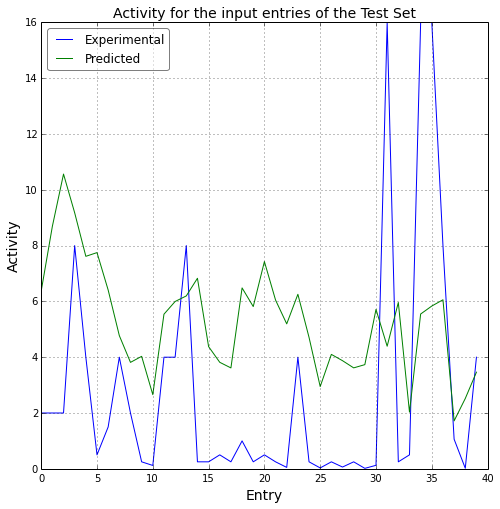

In [7]:
#Grafica la actividad predicha y experimental del Test Set
figure(figsize=(8,8)); hold=True
plot(mic_test, label='Experimental')
plot(modelo(matriz_propiedades_test, parametros_sin_error), label='Predicted')
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Activity for the input entries of the Test Set', fontsize=tamano)
xlabel('Entry', fontsize=tamano)
ylabel('Activity', fontsize=tamano)
xlim(0,len(filasTest))
grid()
savefig(Nombre + '/ActTestSet.png')

In [8]:
#Agrega el valor de CODE un array
def CODEfunc(array, params):
    for i in range(0, len(array[:,0])):
        for j in range(0, len(params)):
            array[i,len(array[0,:])-1]+=params[j]*array[i,len(array[0,:])-1-len(params)+j]
    return array

#Define un nuevo array con la columna de code
DatosArreg_code = CODEfunc(DatosArreg, parametros_sin_error)

In [12]:
#Ordena el array de menor a mayor segun los valores de numcol
def Ordenador(array, numcol):
    
    Ordered=array[array[:,numcol].argsort()]
    
    return Ordered